In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import requests
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import geodatasets
import sqlite3

In [166]:
#load dataset
victims_coords = pd.read_csv('victims_coords.csv')

victims_coords

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
258,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,NaN,38.233259,-109.920663
259,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,NaN,45.209965,-121.723232
260,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,NaN,45.209965,-121.723232
261,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,NaN,38.331613,-80.310683


In [167]:
#looking at overall info in dataset
victims_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       263 non-null    object 
 1   age        263 non-null    object 
 2   park       263 non-null    object 
 3   state      263 non-null    object 
 4   year       263 non-null    int64  
 5   notes      20 non-null     object 
 6   latitude   263 non-null    float64
 7   longitude  263 non-null    float64
dtypes: float64(2), int64(1), object(5)
memory usage: 16.6+ KB


In [168]:
#checking data types
print("Original Data Types:")
print(victims_coords.dtypes)

Original Data Types:
name          object
age           object
park          object
state         object
year           int64
notes         object
latitude     float64
longitude    float64
dtype: object


In [169]:
victims_coords.describe()

,year,latitude,longitude
count,263.000000,263.000000,263.000000
mean,1996.281369,39.510005,-111.646526
std,23.065388,7.811641,16.408648
min,1909.000000,-32.033425,-155.729700
25%,1983.500000,36.174418,-121.025532
50%,2002.000000,37.839300,-118.146842
75%,2015.000000,44.038244,-109.315598
max,2024.000000,61.280047,-52.099130


In [170]:
#looking at layout
victims_coords.head(10)

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
5,Sharon Buis,48,Glacier Bay National Park,Alaska,2014,body found,58.814175,-136.872094
6,Jonghyon Won,45,Grand Canyon,Arizona,2017,NaN,36.097743,-112.096762
7,Floyed E. Roberts III,52,Grand Canyon,Arizona,2016,NaN,36.097743,-112.096762
8,Morgan Heimer,22,Grand Canyon,Arizona,2015,NaN,36.097743,-112.096762
9,Drake Kramer,21,Grand Canyon,Arizona,2015,NaN,36.097743,-112.096762


In [171]:
#check for duplicates
victims_coords.duplicated().sum()

#print(victims_coords.duplicated().sum())

#remove duplicates
victims_coords = victims_coords.drop_duplicates()

#found 2 duplicate rows
victims_coords

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
258,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,NaN,38.233259,-109.920663
259,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,NaN,45.209965,-121.723232
260,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,NaN,45.209965,-121.723232
261,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,NaN,38.331613,-80.310683


In [172]:
#find missing values
missing_values = victims_coords.isnull()
missing_values

#Count missing values in each column
print(victims_coords.isna().sum())


name           0
age            0
park           0
state          0
year           0
notes        241
latitude       0
longitude      0
dtype: int64


In [173]:
#notes column missing 240 out of 261 rows of information so need to delete

victims_coords = victims_coords.drop(columns=['notes']) 

print(victims_coords.columns)

Index(['name', 'age', 'park', 'state', 'year', 'latitude', 'longitude'], dtype='object')


In [174]:
#manually found all the missing lat and long values and added them into dataset
#used google maps to find coordinates based on location information
missing_values

missing_values.isnull()

missing_values.any(axis=1)
missing_values[missing_values.any(axis=1)]  


,name,age,park,state,year,notes,latitude,longitude
0,False,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False,False
3,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
258,False,False,False,False,False,True,False,False
259,False,False,False,False,False,True,False,False
260,False,False,False,False,False,True,False,False
261,False,False,False,False,False,True,False,False


In [177]:
# rename 'state' column to 'state_name' and 'name' to 'victim_name'
victims_coords = victims_coords.rename(columns={'state': 'state_name', 'name': 'victim_name'})


In [178]:
victims_coords

,victim_name,age,park,state_name,year,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...
258,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
259,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
260,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
261,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [145]:
#converted the age unspecified and blank values to NaN
victims_coords.replace({'age': {'age unspecified': np.nan, '': np.nan}}, inplace=True)
print(victims_coords)




                        name  age                            park  \
0       David Michael Burney   46        Bankhead National Forest   
1          James Taylor Wall   30        Bankhead National Forest   
2       Kevin Robert O’Keefe   36       Glacier Bay National Park   
3           Micheal LeMaitre   65                    Mt. Marathon   
4              Sandra Gelber   61       Glacier Bay National Park   
..                       ...  ...                             ...   
258        Frederick Gabriel   56       Canyonlands National Park   
259   Carroll Donald Parkins   78        Mt. Hood National Forest   
260      Caleb Josiah Howard   32        Mt. Hood National Forest   
261      Cassie Renee Sheetz   24     Monongahela National Forest   
262  Raymond Aronld Saunders   44   Smoky Mountains National Park   

              state  year   latitude   longitude  
0           Alabama  2007  34.301863  -87.414071  
1           Alabama  2015  34.301863  -87.414071  
2            Alask

In [ ]:
# add new column 'missing_persons_id' with unique identifier for each row and making it the first column
victims_coords.insert(0, 'missing_persons_id', range(1, 1 + len(victims_coords)))

# Step 3: Save the modified DataFrame back to CSV
victims_coords.to_csv('victims_coords.csv', index=False)

In [258]:
victims_coords

,missing_persons_id,victim_name,age,park,state_name,year,latitude,longitude
0,1,David Michael Burney,46,Bankhead National Forest,Alabama,2007,34.301863,-87.414071
1,2,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,34.301863,-87.414071
2,3,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,58.814175,-136.872094
3,4,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,61.280047,-147.224095
4,5,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
258,257,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,38.233259,-109.920663
259,258,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,45.209965,-121.723232
260,259,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,45.209965,-121.723232
261,260,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,38.331613,-80.310683


In [56]:
#set display option to see all rows so that I can find all missing values in dataset
pd.set_option('display.max_rows', None)

#set back to default rows after finding missing values
pd.set_option('display.max_rows', 10)   


In [146]:
#count occurrences
location_counts = victims_coords['park'].value_counts()

#count most frequent location
most_frequent_location = location_counts.idxmax()

#get the most frequent location
print('Most Frequent Location:', most_frequent_location)

Most Frequent Location: Yosemite National Park


In [147]:
# Convert 'age' column to numeric, coercing errors to NaN
victims_coords['age'] = pd.to_numeric(victims_coords['age'], errors='coerce')

# youngest victim
youngest_age = victims_coords['age'].min()
print("The youngest age is:", youngest_age)

# oldest victim
oldest_age = victims_coords['age'].max()
print("The oldest age is:", oldest_age)

#average age of victims
average_age = victims_coords['age'].mean()
print("The average age is:", average_age)

The youngest age is: 2.0
The oldest age is: 90.0
The average age is: 37.789256198347104


In [59]:
#check total number of victims for each location
victims_coords['park'].value_counts()

park
Yosemite National Park                 39
Grand Canyon                            8
Great Smoky Mountains National Park     7
Plumas National Forest                  5
Yellowstone National Park               5
                                       ..
 Canyonlands National Park              1
 Mt. Hood National Forest               1
  Mt. Hood National Forest              1
 Monongahela National Forest            1
 Smoky Mountains National Park          1
Name: count, Length: 147, dtype: int64

In [60]:
# GPS coordinates that the Appalachian Mountains cover
lat_min, lat_max = 34.000000, 47.000000
lon_min, lon_max = -80.000000, -70.000000  # -80 is west, -70 is east

# Find total amount of missing people inside the boundaries of the Appalachian Mountains using GPS coordinates
appalachian_mtn_victims = victims_coords[
	victims_coords['latitude'].between(lat_min, lat_max) &
	victims_coords['longitude'].between(lon_min, lon_max)
]

appalachian_mtn_victims.shape[0]  # total number of victims in the Appalachian Mountains

11

In [148]:
#check top 10 years with most victims
victims_coords['year'].value_counts().head(10)


year
2015    16
2017    11
2006    11
2010    10
2019     9
1996     8
2016     8
1998     8
1978     7
2021     7
Name: count, dtype: int64

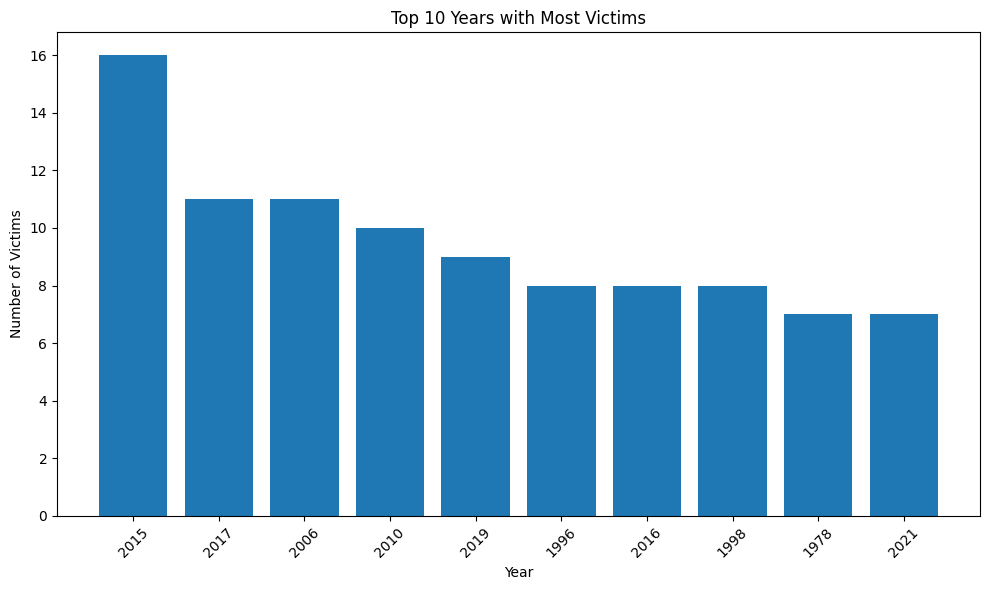

In [62]:
#visualize top 10 years with most victims
plt.figure(figsize=(10,6))
top_years = victims_coords['year'].value_counts().head(10)
plt.bar(top_years.index.astype(str), top_years.values)
plt.xlabel('Year')
plt.ylabel('Number of Victims')
plt.title('Top 10 Years with Most Victims')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
# Chose a bar plot to visualize the top 10 years with most victims because it effectively displays categorical data, allowing for easy comparison of the number of victims across different years.
# I used blue for the bars because it is a neutral color and stands out well against the white background.
# The labels and titles are clear and descriptive, making it easy to understand the information being presented.


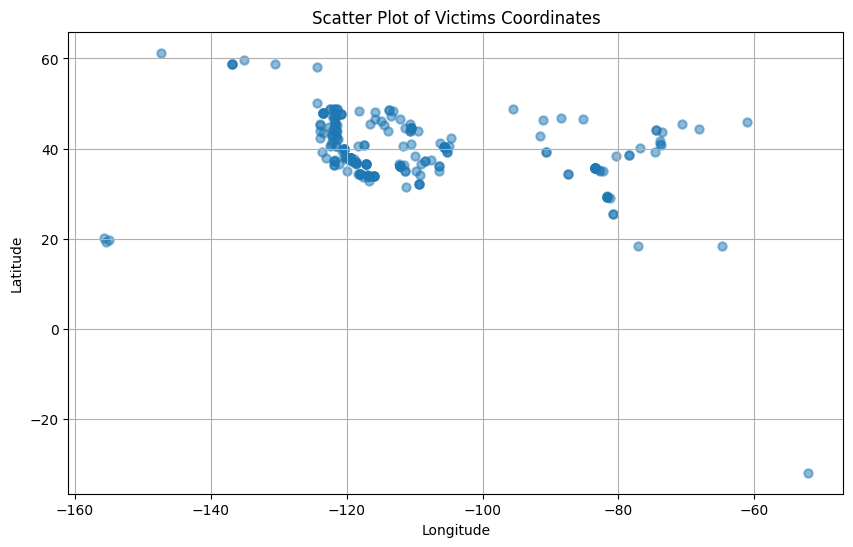

In [64]:
plt.figure(figsize=(10,6))
plt.scatter(victims_coords['longitude'], victims_coords['latitude'], linewidths=1.5, alpha=0.5)
plt.title('Scatter Plot of Victims Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [65]:
# I chose a scatter plot to visualize the distribution of victims' coordinates because it effectively displays the geographical spread of incidents. Each point represents a victim's location, allowing us to identify clusters or patterns in specific areas. The scatter plot provides a clear visual representation of how victims are distributed across different longitudes and latitudes, making it easier to analyze spatial relationships and trends in the data...
# This type of plot is useful for identifying areas with higher concentrations of victims
 


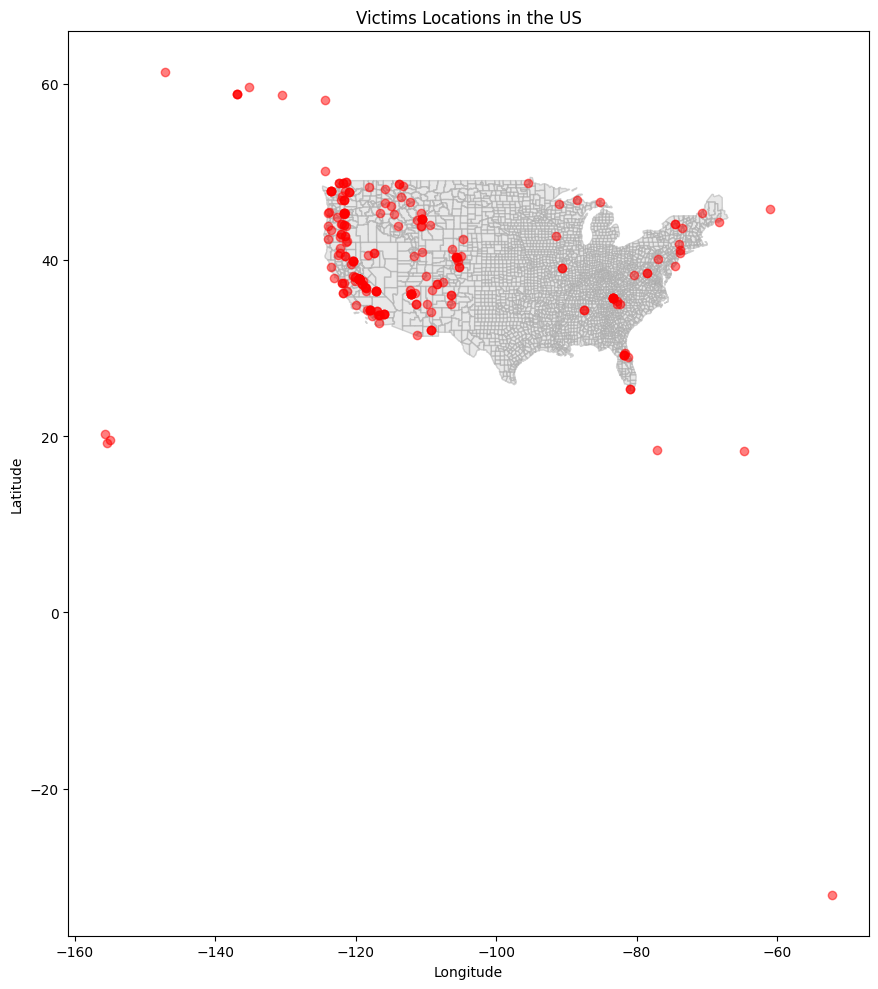

In [214]:
# create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(victims_coords['longitude'], victims_coords['latitude'], color='red', alpha=0.5)
ax.set_title('Victims Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [36]:
# I installed and used the geopandas library to create a scatter plot with a US map background.
# Like the previous scatter plot, this visualization effectively displays the geographical distribution of victims across the United States. By overlaying the victims' coordinates on a map of the US, it provides a clearer context for understanding where incidents are concentrated in relation to state boundaries and geographical features. This type of plot is particularly useful for identifying regional patterns and hotspots, making it easier to analyze spatial relationships and trends in the data on a national scale.
# By using the map background, you can start to see where the clusters of victims are located in relation to the states and regions of the US.
# You can now see there is a cluster of victims in the Appalachian Mountain region as well as some in the western US, near Grand Teton National Park in Wyoming.
# I chose red so that the points stand out against the light gray background. Also, because red is often associated with urgency and danger.

In [179]:
#load new dataset
bfro_locations = pd.read_csv('bfro_locations.csv')

bfro_locations

,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [180]:
bfro_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number          4309 non-null   int64  
 1   title           4309 non-null   object 
 2   classification  4309 non-null   object 
 3   timestamp       4309 non-null   object 
 4   latitude        4309 non-null   float64
 5   longitude       4309 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 202.1+ KB


In [75]:
bfro_locations.describe()

,number,latitude,longitude
count,4309.000000,4309.000000,4.309000e+03
mean,23270.103504,39.838115,-6.593093e+04
std,19781.610023,6.009804,2.015040e+06
min,60.000000,25.141000,-9.486840e+07
25%,7003.000000,35.626700,-1.180883e+02
50%,17570.000000,39.641930,-9.232704e+01
75%,35427.000000,44.825000,-8.311422e+01
max,75577.000000,64.891390,-6.383683e+01


In [76]:
#check for duplicates
bfro_locations.duplicated().sum()

#no duplicates found

np.int64(0)

In [181]:
#find missing values
missing_values = bfro_locations.isnull()
missing_values

#Count missing values in each column
print(bfro_locations.isna().sum())

number            0
title             0
classification    0
timestamp         0
latitude          0
longitude         0
dtype: int64


In [182]:
bfro_locations


,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [226]:
# find city in 'title' column and create new 'city' column
bfro_locations['city'] = bfro_locations['title'].str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')
bfro_locations

# delete 'city' column                      
bfro_locations = bfro_locations.drop(columns=['city']) 

bfro_locations

,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [228]:
bfro_locations = bfro_locations.rename(columns={'number': 'bigfoot_sighting_id', 'title': 'description'})

bfro_locations

,bigfoot_sighting_id,description,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...
4304,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4305,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4306,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4307,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


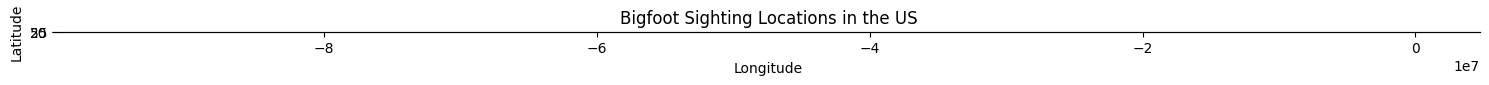

In [229]:
# create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(bfro_locations['longitude'], bfro_locations['latitude'], color='red', alpha=0.5)
ax.set_title('Bigfoot Sighting Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()


In [90]:
updated_us_cave_systems = pd.read_csv('updated_us_cave_systems.csv')

updated_us_cave_systems



,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,NaN
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,NaN
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,NaN
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,NaN
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,NaN
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,NaN
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,NaN
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,NaN


In [43]:
updated_us_cave_systems['Coordinates'] = updated_us_cave_systems['Coordinates'].fillna('35.16.33.6.N111.35.35.0W / 35.16.32.3N111.35.31.2W')

In [44]:
updated_us_cave_systems = pd.read_csv('updated_us_cave_systems.csv')

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"near Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,NaN
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"near Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,NaN
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"near Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,NaN
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"near Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,NaN
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"near Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"near Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,NaN
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,NaN
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,NaN
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,NaN


In [132]:


updated_us_cave_systems

,cave_id,name,length,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [133]:
# Create new column by splitting the 'coordinates' column and extracting value after ; into 'longitude' column
updated_us_cave_systems['longitude'] = updated_us_cave_systems['Coordinates'].str.split('; ').str[1]

# create new column by splitting the 'coordinates' column and extracting value after // and before ; into 'latitude' column
updated_us_cave_systems['latitude'] = updated_us_cave_systems['Coordinates'].str.split('; ').str[0]

# delete all value before // in latitude column
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude'].str.split('//').str[1]

#why is latitude column outputting NaN values?
updated_us_cave_systems


updated_us_cave_systems




,cave_id,name,length,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


In [93]:
import re

def dms_to_dd(d, m, s, hem):
    dd = float(d) + float(m) / 60 + float(s) / 3600
    if hem.upper() in ('S', 'W'):
        dd = -dd
    return dd

# regexes to match decimal degrees with direction, plain signed decimals, and DMS
dec_with_dir = re.compile(r'([0-9]{1,3}\.\d+)[°\s]*([NnSs]).*?([0-9]{1,3}\.\d+)[°\s]*([EeWw])')
signed_dec = re.compile(r'-?\d+\.\d+')
dms_pair = re.compile(r'(\d{1,3})[°\s]+(\d{1,2})[\'′\s]+(\d{1,2}(?:\.\d+)?)[\"″\s]*([NnSsEeWw])')

def parse_coordinates(s):
    if pd.isna(s):
        return pd.Series([np.nan, np.nan])

    # 1) decimal degrees with N/S and E/W (e.g. "37.18758°N 86.10357°W")
    m = dec_with_dir.search(s)
    if m:
        lat = float(m.group(1)) * (1 if m.group(2).upper() == 'N' else -1)
        lon = float(m.group(3)) * (1 if m.group(4).upper() == 'E' else -1)
        return pd.Series([lat, lon])

    # 2) any two signed decimals appearing in the string (heuristic)
    nums = signed_dec.findall(s)
    if len(nums) >= 2:
        a, b = map(float, nums[:2])
        # heuristic: latitude must be within [-90, 90]
        if abs(a) <= 90 and abs(b) <= 180:
            return pd.Series([a, b])
        if abs(b) <= 90 and abs(a) <= 180:
            return pd.Series([b, a])
        return pd.Series([np.nan, np.nan])

    # 3) try parsing two DMS occurrences (degree/min/sec + direction)
    dms_matches = dms_pair.findall(s)
    if len(dms_matches) >= 2:
        lat = dms_to_dd(dms_matches[0][0], dms_matches[0][1], dms_matches[0][2], dms_matches[0][3])
        lon = dms_to_dd(dms_matches[1][0], dms_matches[1][1], dms_matches[1][2], dms_matches[1][3])
        return pd.Series([lat, lon])

    return pd.Series([np.nan, np.nan])

# parse and write back into the dataframe
updated_us_cave_systems[['latitude_parsed', 'longitude_parsed']] = updated_us_cave_systems['Coordinates'].apply(parse_coordinates)

# fill the missing latitude (was all NaN) and clean/merge longitude
updated_us_cave_systems['latitude'] = updated_us_cave_systems['latitude_parsed']

# try to extract a clean numeric longitude from the existing 'longitude' column, otherwise use parsed
existing_lon_num = updated_us_cave_systems['longitude'].astype(str).str.extract(r'(-?\d+\.\d+)')[0].astype(float)
updated_us_cave_systems['longitude'] = existing_lon_num.fillna(updated_us_cave_systems['longitude_parsed'])

# drop helper columns
updated_us_cave_systems.drop(columns=['latitude_parsed', 'longitude_parsed'], inplace=True)

# show results
updated_us_cave_systems[['Coordinates', 'latitude', 'longitude']]


,Coordinates,latitude,longitude
0,37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,37.187580,-86.103570
1,43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,43.729440,-103.829440
2,43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,43.558040,-103.479550
3,32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,32.190642,-104.503309
4,37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,37.187300,-85.975100
...,...,...,...
14,32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,32.177057,-104.441039
15,37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,37.718156,-80.436298
16,30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,30.235415,-84.302875
17,37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,37.119600,-86.136200


In [94]:
updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200


In [100]:
# separate 'Location' column into two separate columns, 'city' and 'state
updated_us_cave_systems['city'] = updated_us_cave_systems['Location'].str.split(', ').str[0]

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude,city,state
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [102]:
# separate 'Location' column into two separate columns, 'city' and 'state
updated_us_cave_systems['state'] = updated_us_cave_systems['Location'].str.split(', ').str[1]

updated_us_cave_systems

,#,System,Length,Location,Coordinates,"Associated parks,\nprotected areas",Access,latitude,longitude,city,state
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Brownsville, Kentucky",37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],37.187580,-86.103570,Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],"Custer, South Dakota",43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],43.729440,-103.829440,Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],"Hot Springs, South Dakota",43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,43.558040,-103.479550,Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],"Carlsbad, New Mexico",32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",32.190642,-104.503309,Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],"Brownsville, Kentucky",37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,37.187300,-85.975100,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],"Carlsbad, New Mexico",32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],32.177057,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],"Greenbrier County, West Virginia",37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,37.718156,-80.436298,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],"Wakulla County, Florida",30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,30.235415,-84.302875,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],"Edmonson County, Kentucky",37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,37.119600,-86.136200,Edmonson County,Kentucky


In [135]:
updated_us_cave_systems.drop('Coordinates', axis=1)


,cave_id,name,length,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


In [230]:
updated_us_cave_systems = updated_us_cave_systems.rename(columns={'#': 'cave_system_id', 'System': 'cave_name', 'Associated parks,\nprotected areas': 'associated_park_restricted_area', 'city': 'city_name', 'state': 'state_name', 'Length': 'length', 'Access': 'access'})

updated_us_cave_systems

,cave_id,name,length,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


In [233]:
updated_us_cave_systems.drop('Coordinates', axis=1)

,cave_system_id,cave_system_name,length,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


In [234]:
updated_us_cave_systems = updated_us_cave_systems.rename(columns={'cave_id': 'cave_system_id', 'name': 'cave_system_name'})

updated_us_cave_systems

,cave_system_id,cave_system_name,length,Coordinates,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],37°11′15″N86°06′13″W﻿ / ﻿37.18758°N 86.10357°W...,"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],43°43′46″N103°49′46″W﻿ / ﻿43.72944°N 103.82944...,Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],43°33′29″N103°28′46″W﻿ / ﻿43.55804°N 103.47955...,Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],32°11′26″N104°30′12″W﻿ / ﻿32.1906420°N 104.503...,Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],37°11′14″N85°58′30″W﻿ / ﻿37.1873°N 85.9751°W﻿ ...,partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],32°10′37″N104°26′28″W﻿ / ﻿32.177057°N 104.4410...,Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],37°43′05″N80°26′11″W﻿ / ﻿37.7181564°N 80.43629...,None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],30°14′07″N84°18′10″W﻿ / ﻿30.2354147°N 84.30287...,None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],37°07′11″N86°08′10″W﻿ / ﻿37.1196°N 86.1362°W﻿ ...,none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


In [235]:
updated_us_cave_systems.drop('Coordinates', axis=1)

,cave_system_id,cave_system_name,length,associated_park_restricted_area,access,latitude,longitude,city_name,state_name
0,1,Mammoth Cave,685.6 km (426.0 mi)[2][3][1],"Mammoth Cave National Park, also a World Herit...",Some public access[4],NaN,-86.10357﻿ (Mammoth \ncave historic entrance),Brownsville,Kentucky
1,2,Jewel Cave,354.86 km (220.5 mi)[5][6][1],Jewel Cave National Monument,Some public access[7],NaN,-103.82944﻿ (Jewel \nCave),Custer,South Dakota
2,3,Wind Cave,270.498 km (168.1 mi)[8][1],Wind Cave National Park,Some public access,NaN,-103.47955﻿ (Wind \nCave),Hot Springs,South Dakota
3,4,Lechuguilla Cave,244.8 km (152.1 mi)[9][10][1],Carlsbad Caverns National Park,"Restricted access, requires authorization[11]",NaN,\n-104.5033091﻿ (Grotte de Lechuguilla),Carlsbad,New Mexico
4,5,Fisher Ridge Cave System,215.908 km (134.2 mi)[1],partly within Mammoth Cave National Park,NaN,NaN,-85.9751﻿ (Fisher \nRidge System Historic Entr...,Brownsville,Kentucky
...,...,...,...,...,...,...,...,...,...
14,15,Carlsbad Caverns,63.5 km (39.46 mi)[19],Carlsbad Caverns National Park,Public access.[24],NaN,-104.441039,Carlsbad,New Mexico
15,16,Organ Cave,61.9 km (38.46 mi)[19],None. Entrances on private property.,Some entrances closed. Some entrances require ...,NaN,\n-80.4362982,Greenbrier County,West Virginia
16,17,Wakulla-Leon Sinks Cave System,56.6 km (35.17 mi)[25],None. Underwater cave system.,NaN,NaN,\n-84.3028754,Wakulla County,Florida
17,18,Whigpistle System,55.7 km (34.61 mi)[26][27],none,NaN,NaN,-86.1362﻿ (Whigpistle \nSystem Whigpistle Entr...,Edmonson County,Kentucky


TypeError: 'value' must be an instance of str or bytes, not a float

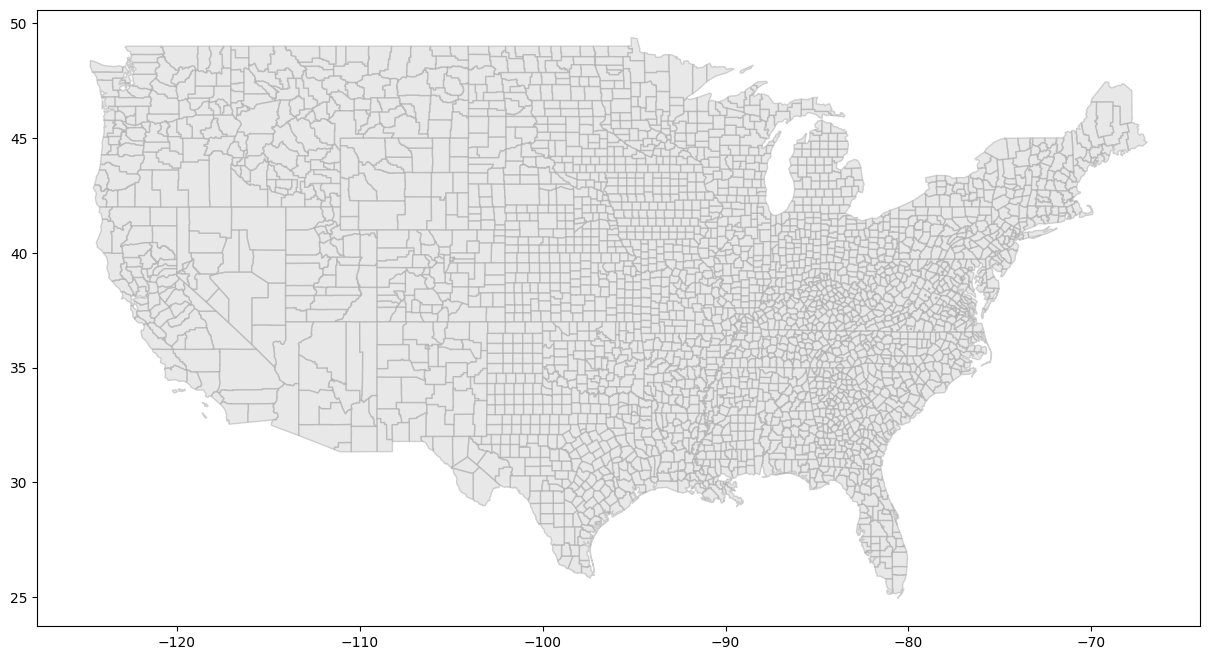

In [185]:
# create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(updated_us_cave_systems['longitude'], updated_us_cave_systems['latitude'], color='red', alpha=0.5)
ax.set_title('Large Cave System Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [266]:

dogman_sightings = pd.read_csv('dogman_sightings_raw.csv', on_bad_lines='warn')

dogman_sightings


/var/folders/07/95ysvbs12sx3tsnr11h95dvh0000gn/T/ipykernel_11765/2056606790.py:1: ParserWarning: Skipping line 4: expected 3 fields, saw 32

  dogman_sightings = pd.read_csv('dogman_sightings_raw.csv', on_bad_lines='warn')


,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [203]:
dogman_sightings.describe()

,title,description,coordinates
count,130,130,130
unique,130,130,122
top,Canada - Alberta,About three years ago i encountered what I cou...,"\n -86.2895052,43.643476,0\n"
freq,1,1,2


In [204]:
dogman_sightings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        130 non-null    object
 1   description  130 non-null    object
 2   coordinates  130 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


In [205]:
dogman_sightings.duplicated().sum()

np.int64(0)

In [206]:
missing_values = dogman_sightings.isnull()

missing_values

print(dogman_sightings.isna().sum())

title          0
description    0
coordinates    0
dtype: int64


In [207]:

# find all NaN values in 'dogman_sightings_raw.csv
dogman_sightings[dogman_sightings['coordinates'].isna()]

dogman_sightings


,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [208]:
# separate 'title' column into two separate columns, 'city' and 'state
dogman_sightings['city'] = dogman_sightings['title'].str.split(' - ').str[1]

dogman_sightings

,title,description,coordinates,city
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick
...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder


In [209]:
# separate 'title' column into two separate columns, 'city' and 'state
dogman_sightings['state'] = dogman_sightings['title'].str.split(' - ').str[0]

dogman_sightings

,title,description,coordinates,city,state
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada
...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming


In [210]:
dogman_sightings['longitude'] = dogman_sightings['coordinates'].str.split(',').str[0]

dogman_sightings

,title,description,coordinates,city,state,longitude
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada,\n -116.5765035
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada,\n -117.458219
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada,\n -94.7748443
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada,\n -73.8059179
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada,\n -66.4619164
...,...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas,\n -96.1526985
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas,\n -100.5387183
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington,\n -122.0981848
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming,\n -109.7205643


In [211]:
dogman_sightings['latitude'] = dogman_sightings['coordinates'].str.split(',').str[1]

dogman_sightings

,title,description,coordinates,city,state,longitude,latitude
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n",Alberta,Canada,\n -116.5765035,53.9332706
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n",Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n",Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ...",Léry Quebec,Canada,\n -73.8059179,45.3444129
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ...",New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ...",Freestone County,Texas,\n -96.1526985,31.7534889
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ...",Roscoe,Texas,\n -100.5387183,32.445952
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ...",Snohomish County,Washington,\n -122.0981848,47.9128756
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ...",Boulder,Wyoming,\n -109.7205643,42.7461611


In [212]:
# delete 'title' and 'coordinates' columns
dogman_sightings= dogman_sightings.drop(columns=['title', 'coordinates'])

dogman_sightings

,description,city,state,longitude,latitude
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611


In [213]:
dogman_sightings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  130 non-null    object
 1   city         130 non-null    object
 2   state        130 non-null    object
 3   longitude    130 non-null    object
 4   latitude     130 non-null    object
dtypes: object(5)
memory usage: 5.2+ KB


In [214]:
dogman_sightings


,description,city,state,longitude,latitude
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163
...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611


In [263]:
#change names of 'city' column' to 'city_name' and 'state' to 'state_name' 
dogman_sightings = dogman_sightings.rename(columns={'city': 'city_name', 'state': 'state_name'})

dogman_sightings

,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [216]:
# find date in 'description' column and create new 'date' column
dogman_sightings['date'] = dogman_sightings['description'].str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')
dogman_sightings

# show all rows in output
pd.set_option('display.max_rows', None)

# show default rows
pd.set_option('display.max_rows', 10)

dogman_sightings

,description,city_name,state_name,longitude,latitude,date
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706,NaN
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963,NaN
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341,NaN
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129,NaN
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163,NaN
...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889,4/23/2016
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952,NaN
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756,NaN
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611,10/15/2010


In [221]:
def season(description): 
    description = description.lower()
    if 'january' in description or 'february' in description or 'december'in description:
        return 'Winter'
    elif 'march' in description or 'april' in description or 'may' in description:
        return 'Spring'
    elif 'june' in description or 'july' in description or 'august' in description:
        return 'Summer'
    elif 'september' in description or 'october' in description or 'november'in description:
        return 'Fall'
    else:
        return 'Unknown' 
        
dogman_sightings['season'] = dogman_sightings['description'].apply(season)          

dogman_sightings

,description,city_name,state_name,longitude,latitude,date,time_of_year,season
0,About three years ago i encountered what I cou...,Alberta,Canada,\n -116.5765035,53.9332706,NaN,Unknown,Unknown
1,I came across another report of a bipedal cani...,Deadwood Alberta 1,Canada,\n -117.458219,56.740963,NaN,Spring,Spring
2,I saw something that put a big scare into me. ...,Gillam Manitoba,Canada,\n -94.7748443,56.33341,NaN,Summer,Summer
3,An old friend and I cross the path of a dogman...,Léry Quebec,Canada,\n -73.8059179,45.3444129,NaN,Spring,Spring
4,My grandfather told me this story when I was a...,New Brunswick,Canada,\n -66.4619164,46.5653163,NaN,Unknown,Unknown
...,...,...,...,...,...,...,...,...
125,4/23/2016 - I was out at my grandparent’s hous...,Freestone County,Texas,\n -96.1526985,31.7534889,4/23/2016,Unknown,Unknown
126,Date Unknown - the first encounter was when i...,Roscoe,Texas,\n -100.5387183,32.445952,NaN,Spring,Spring
127,1997-98 - My first encounter happened late at ...,Snohomish County,Washington,\n -122.0981848,47.9128756,NaN,Spring,Spring
128,Name:<br>Ken<br>Report Title:<br>Encounter out...,Boulder,Wyoming,\n -109.7205643,42.7461611,10/15/2010,Unknown,Unknown


In [256]:
dogman_sightings


,title,description,coordinates
0,Canada - Alberta,About three years ago i encountered what I cou...,"\n -116.5765035,53.9332706,0\n"
1,Canada - Deadwood Alberta 1,I came across another report of a bipedal cani...,"\n -117.458219,56.740963,0\n"
2,Canada - Gillam Manitoba,I saw something that put a big scare into me. ...,"\n -94.7748443,56.33341,0\n"
3,Canada - Léry Quebec,An old friend and I cross the path of a dogman...,"\n -73.8059179,45.3444129,0\n ..."
4,Canada - New Brunswick,My grandfather told me this story when I was a...,"\n -66.4619164,46.5653163,0\n ..."
...,...,...,...
125,Texas - Freestone County,4/23/2016 - I was out at my grandparent’s hous...,"\n -96.1526985,31.7534889,0\n ..."
126,Texas - Roscoe,Date Unknown - the first encounter was when i...,"\n -100.5387183,32.445952,0\n ..."
127,Washington - Snohomish County,1997-98 - My first encounter happened late at ...,"\n -122.0981848,47.9128756,0\n ..."
128,Wyoming - Boulder,Name:<br>Ken<br>Report Title:<br>Encounter out...,"\n -109.7205643,42.7461611,0\n ..."


In [273]:

# Step 1: Establish a connection to the SQLite database
conn = sqlite3.connect('sightings_database.db')

# close the connection
conn.close()

In [ ]:

conn = sqlite3.connect('sightings_database.db')

In [269]:
# Step 2: Load your CSV files into Pandas DataFrames
BigfootSightings_df = pd.read_csv('bfro_locations.csv')
DogmanSightings_df = pd.read_csv('dogman_sightings_raw.csv',  on_bad_lines='warn')
MissingPersons_df = pd.read_csv('victims_coords.csv')
CaveSystems_df = pd.read_csv('updated_us_cave_systems.csv')

/var/folders/07/95ysvbs12sx3tsnr11h95dvh0000gn/T/ipykernel_11765/3348337177.py:3: ParserWarning: Skipping line 4: expected 3 fields, saw 32

  DogmanSightings_df = pd.read_csv('dogman_sightings_raw.csv',  on_bad_lines='warn')


In [276]:
conn.close()